# 05 — Model 3: Neural Collaborative Filtering
## Fitness Workout Recommender

A PyTorch neural network that learns non-linear user-exercise interactions.
Combines embedding layers (like matrix factorization) with deep layers (MLP)
to capture complex preference patterns.

Reference: He et al., 'Neural Collaborative Filtering' (WWW 2017)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
np.random.seed(42)
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'PyTorch {torch.__version__}, device: {device}')

PyTorch 2.10.0, device: cpu


In [2]:
exercises = pd.read_csv('../data/processed/exercises_clean.csv')
users = pd.read_csv('../data/processed/user_profiles.csv')
interactions = pd.read_csv('../data/processed/user_exercise_interactions.csv')

print(f'Exercises: {len(exercises)}, Users: {len(users)}, Interactions: {len(interactions)}')

Exercises: 52, Users: 1000, Interactions: 15000


## 1. Prepare Data

In [3]:
# Same train/test split as previous notebooks
train_interactions = []
test_interactions = []

for user_id in interactions['user_id'].unique():
    user_ints = interactions[interactions['user_id'] == user_id]
    if len(user_ints) >= 4:
        train, test = train_test_split(user_ints, test_size=0.2, random_state=42)
        train_interactions.append(train)
        test_interactions.append(test)
    else:
        train_interactions.append(user_ints)

train_df = pd.concat(train_interactions).reset_index(drop=True)
test_df = pd.concat(test_interactions).reset_index(drop=True)

# Ground truth
ground_truth = {}
for user_id in test_df['user_id'].unique():
    user_test = test_df[test_df['user_id'] == user_id]
    liked = set(user_test[user_test['rating'] >= 3.0]['exercise_id'].values)
    if liked:
        ground_truth[user_id] = liked

print(f'Train: {len(train_df)}, Test: {len(test_df)}, GT users: {len(ground_truth)}')

Train: 12000, Test: 3000, GT users: 919


In [4]:
# Encode IDs to sequential integers
user_ids_sorted = sorted(users['user_id'].unique())
exercise_ids_sorted = sorted(exercises['exercise_id'].unique())

user_to_idx = {uid: i for i, uid in enumerate(user_ids_sorted)}
exercise_to_idx = {eid: i for i, eid in enumerate(exercise_ids_sorted)}
idx_to_exercise = {i: eid for eid, i in exercise_to_idx.items()}

n_users = len(user_to_idx)
n_exercises = len(exercise_to_idx)

# Normalize ratings to [0, 1]
max_rating = train_df['rating'].max()
train_df['rating_norm'] = train_df['rating'] / max_rating

print(f'Users: {n_users}, Exercises: {n_exercises}')

Users: 1000, Exercises: 52


In [5]:
# PyTorch Dataset
class InteractionDataset(Dataset):
    def __init__(self, df, user_to_idx, exercise_to_idx):
        self.users = torch.LongTensor([user_to_idx[u] for u in df['user_id']])
        self.exercises = torch.LongTensor([exercise_to_idx[e] for e in df['exercise_id']])
        self.ratings = torch.FloatTensor(df['rating_norm'].values)
    
    def __len__(self): return len(self.ratings)
    def __getitem__(self, idx): return self.users[idx], self.exercises[idx], self.ratings[idx]

# Split training data into train/val for the neural model
train_split, val_split = train_test_split(train_df, test_size=0.1, random_state=42)
val_split['rating_norm'] = val_split['rating'] / max_rating

train_dataset = InteractionDataset(train_split, user_to_idx, exercise_to_idx)
val_dataset = InteractionDataset(val_split, user_to_idx, exercise_to_idx)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

print(f'Train batches: {len(train_loader)}, Val batches: {len(val_loader)}')

Train batches: 43, Val batches: 5


## 2. Define the NCF Model

Architecture:
- **GMF pathway**: Element-wise product of user/exercise embeddings (like matrix factorization)
- **MLP pathway**: Concatenated embeddings through hidden layers (learns non-linear patterns)
- **Fusion**: Merge both pathways for final prediction

In [6]:
class NeuralCF(nn.Module):
    def __init__(self, n_users, n_exercises, n_factors=32, hidden_layers=[64, 32, 16], dropout=0.2):
        super().__init__()
        
        # GMF pathway
        self.user_emb_gmf = nn.Embedding(n_users, n_factors)
        self.exercise_emb_gmf = nn.Embedding(n_exercises, n_factors)
        
        # MLP pathway
        self.user_emb_mlp = nn.Embedding(n_users, n_factors)
        self.exercise_emb_mlp = nn.Embedding(n_exercises, n_factors)
        
        # MLP layers
        mlp_layers = []
        input_size = n_factors * 2
        for hidden_size in hidden_layers:
            mlp_layers.append(nn.Linear(input_size, hidden_size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.BatchNorm1d(hidden_size))
            mlp_layers.append(nn.Dropout(dropout))
            input_size = hidden_size
        self.mlp = nn.Sequential(*mlp_layers)
        
        # Final prediction
        self.predict = nn.Linear(n_factors + hidden_layers[-1], 1)
        self.sigmoid = nn.Sigmoid()
        
        self._init_weights()
    
    def _init_weights(self):
        for emb in [self.user_emb_gmf, self.exercise_emb_gmf, self.user_emb_mlp, self.exercise_emb_mlp]:
            nn.init.normal_(emb.weight, std=0.01)
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
        nn.init.xavier_uniform_(self.predict.weight)
    
    def forward(self, user_ids, exercise_ids):
        # GMF
        gmf_out = self.user_emb_gmf(user_ids) * self.exercise_emb_gmf(exercise_ids)
        
        # MLP
        mlp_input = torch.cat([self.user_emb_mlp(user_ids), self.exercise_emb_mlp(exercise_ids)], dim=-1)
        mlp_out = self.mlp(mlp_input)
        
        # Merge & predict
        concat = torch.cat([gmf_out, mlp_out], dim=-1)
        return self.sigmoid(self.predict(concat)).squeeze()

model = NeuralCF(n_users, n_exercises, n_factors=32, hidden_layers=[64, 32, 16], dropout=0.2).to(device)
print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')

NeuralCF(
  (user_emb_gmf): Embedding(1000, 32)
  (exercise_emb_gmf): Embedding(52, 32)
  (user_emb_mlp): Embedding(1000, 32)
  (exercise_emb_mlp): Embedding(52, 32)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
  )
  (predict): Linear(in_features=48, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 74,369


## 3. Train the Model

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
EPOCHS = 30

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Train
    model.train()
    epoch_loss = 0
    for users_batch, exercises_batch, ratings_batch in train_loader:
        users_batch = users_batch.to(device)
        exercises_batch = exercises_batch.to(device)
        ratings_batch = ratings_batch.to(device)
        
        optimizer.zero_grad()
        predictions = model(users_batch, exercises_batch)
        loss = criterion(predictions, ratings_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(ratings_batch)
    
    train_loss = epoch_loss / len(train_dataset)
    train_losses.append(train_loss)
    
    # Validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for users_batch, exercises_batch, ratings_batch in val_loader:
            users_batch = users_batch.to(device)
            exercises_batch = exercises_batch.to(device)
            ratings_batch = ratings_batch.to(device)
            predictions = model(users_batch, exercises_batch)
            val_loss += criterion(predictions, ratings_batch).item() * len(ratings_batch)
    
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1:3d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

print('\nTraining complete!')

Epoch   5/30 | Train Loss: 0.0281 | Val Loss: 0.0293
Epoch  10/30 | Train Loss: 0.0153 | Val Loss: 0.0198
Epoch  15/30 | Train Loss: 0.0106 | Val Loss: 0.0176
Epoch  20/30 | Train Loss: 0.0079 | Val Loss: 0.0173
Epoch  25/30 | Train Loss: 0.0061 | Val Loss: 0.0171
Epoch  30/30 | Train Loss: 0.0048 | Val Loss: 0.0176

Training complete!


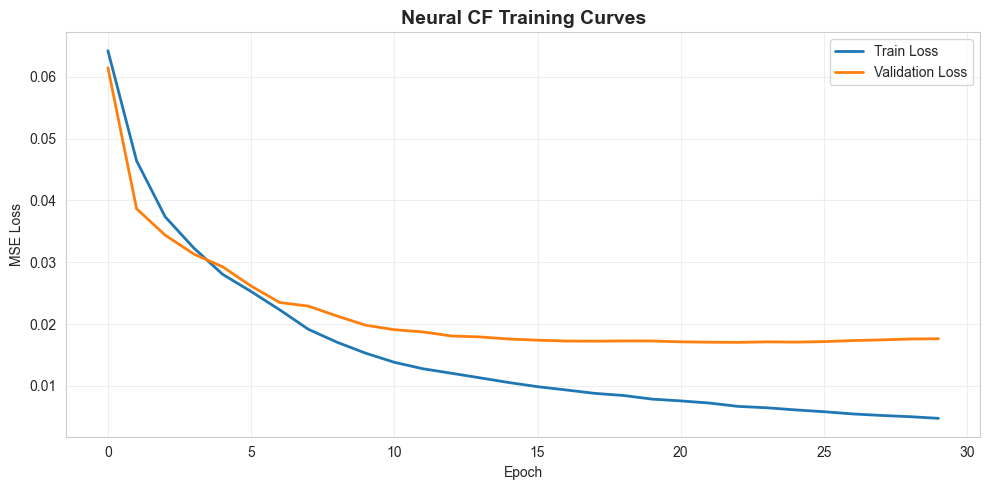

In [8]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Neural CF Training Curves', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/10_ncf_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Generate Recommendations & Evaluate

In [9]:
def recommend_ncf(user_id, model, train_df, user_to_idx, exercise_to_idx, idx_to_exercise, top_k=10):
    model.eval()
    u_idx = user_to_idx[user_id]
    
    train_eids = set(train_df[train_df['user_id'] == user_id]['exercise_id'].values)
    
    candidate_eids = [eid for eid in exercise_to_idx if eid not in train_eids]
    candidate_indices = [exercise_to_idx[eid] for eid in candidate_eids]
    
    with torch.no_grad():
        user_tensor = torch.LongTensor([u_idx] * len(candidate_indices)).to(device)
        exercise_tensor = torch.LongTensor(candidate_indices).to(device)
        scores = model(user_tensor, exercise_tensor).cpu().numpy()
    
    results = sorted(zip(candidate_eids, scores), key=lambda x: x[1], reverse=True)
    return [eid for eid, _ in results[:top_k]]

# Test
test_recs = recommend_ncf('user_0000', model, train_df, user_to_idx, exercise_to_idx, idx_to_exercise)
print('User 0 NCF recommendations:')
for eid in test_recs:
    ex = exercises[exercises['exercise_id'] == eid].iloc[0]
    print(f'  {ex["exercise_name"]:40s} | {ex["body_part"]:12s} | {ex["equipment"]:12s}')

User 0 NCF recommendations:
  fat grip dumbbell curl                   | forearms     | dumbbells   
  incline dumbbell flyes                   | chest        | dumbbells   
  decline dumbbell press                   | chest        | dumbbells   
  dumbbell front raises                    | shoulders    | dumbbells   
  incline dumbbell press                   | chest        | dumbbells   
  face pulls                               | shoulders    | other       
  lateral raises                           | shoulders    | other       
  crunches                                 | abs          | bodyweight  
  chest flyes                              | chest        | other       
  hyperextensions                          | back         | bodyweight  


In [10]:
# Evaluation metrics
def precision_at_k(rec, rel, k): return len(set(rec[:k]) & rel) / k
def recall_at_k(rec, rel, k): return len(set(rec[:k]) & rel) / len(rel) if rel else 0.0
def ndcg_at_k(rec, rel, k):
    dcg = sum(1.0/np.log2(i+2) for i, item in enumerate(rec[:k]) if item in rel)
    idcg = sum(1.0/np.log2(i+2) for i in range(min(len(rel), k)))
    return dcg/idcg if idcg > 0 else 0.0
def hit_rate_at_k(rec, rel, k): return 1.0 if set(rec[:k]) & rel else 0.0

K_VALUES = [5, 10]
results = {k: {'precision': [], 'recall': [], 'ndcg': [], 'hit_rate': []} for k in K_VALUES}

for user_id, relevant in ground_truth.items():
    rec_ids = recommend_ncf(user_id, model, train_df, user_to_idx, exercise_to_idx, idx_to_exercise, top_k=20)
    for k in K_VALUES:
        results[k]['precision'].append(precision_at_k(rec_ids, relevant, k))
        results[k]['recall'].append(recall_at_k(rec_ids, relevant, k))
        results[k]['ndcg'].append(ndcg_at_k(rec_ids, relevant, k))
        results[k]['hit_rate'].append(hit_rate_at_k(rec_ids, relevant, k))

print('=== Neural Collaborative Filtering Results ===')
print(f'{"Metric":<20} {"@5":>10} {"@10":>10}')
print('-' * 42)
for metric in ['precision', 'recall', 'ndcg', 'hit_rate']:
    vals = [np.mean(results[k][metric]) for k in K_VALUES]
    print(f'{metric:<20} {vals[0]:>10.4f} {vals[1]:>10.4f}')

=== Neural Collaborative Filtering Results ===
Metric                       @5        @10
------------------------------------------
precision                0.1099     0.0953
recall                   0.2925     0.5025
ndcg                     0.2103     0.2917
hit_rate                 0.4701     0.7214


In [11]:
# Save results
ncf_results = {}
for k in K_VALUES:
    for metric in ['precision', 'recall', 'ndcg', 'hit_rate']:
        ncf_results[f'{metric}@{k}'] = float(np.mean(results[k][metric]))

with open('../results/metrics/neural_cf_results.json', 'w') as f:
    json.dump(ncf_results, f, indent=2)

print('Results saved!')

Results saved!


## 5. Full Model Comparison

In [12]:
# Load all results
with open('../results/metrics/content_based_results.json', 'r') as f:
    cb = json.load(f)
with open('../results/metrics/collaborative_filtering_results.json', 'r') as f:
    cf = json.load(f)
ncf = ncf_results

print(f'{"Metric":<20} {"Content-Based":>15} {"SVD":>15} {"Neural CF":>15} {"Best":>10}')
print('=' * 77)
for key in cb:
    vals = [cb[key], cf[key], ncf[key]]
    names = ['CB', 'SVD', 'NCF']
    best = names[np.argmax(vals)]
    print(f'{key:<20} {vals[0]:>15.4f} {vals[1]:>15.4f} {vals[2]:>15.4f} {best:>10}')

Metric                 Content-Based             SVD       Neural CF       Best
precision@5                   0.1071          0.0810          0.1099        NCF
recall@5                      0.2795          0.2067          0.2925        NCF
ndcg@5                        0.2029          0.1511          0.2103        NCF
hit_rate@5                    0.4744          0.3591          0.4701         CB
precision@10                  0.0937          0.0741          0.0953        NCF
recall@10                     0.4857          0.3818          0.5025        NCF
ndcg@10                       0.2828          0.2184          0.2917        NCF
hit_rate@10                   0.7138          0.5963          0.7214        NCF


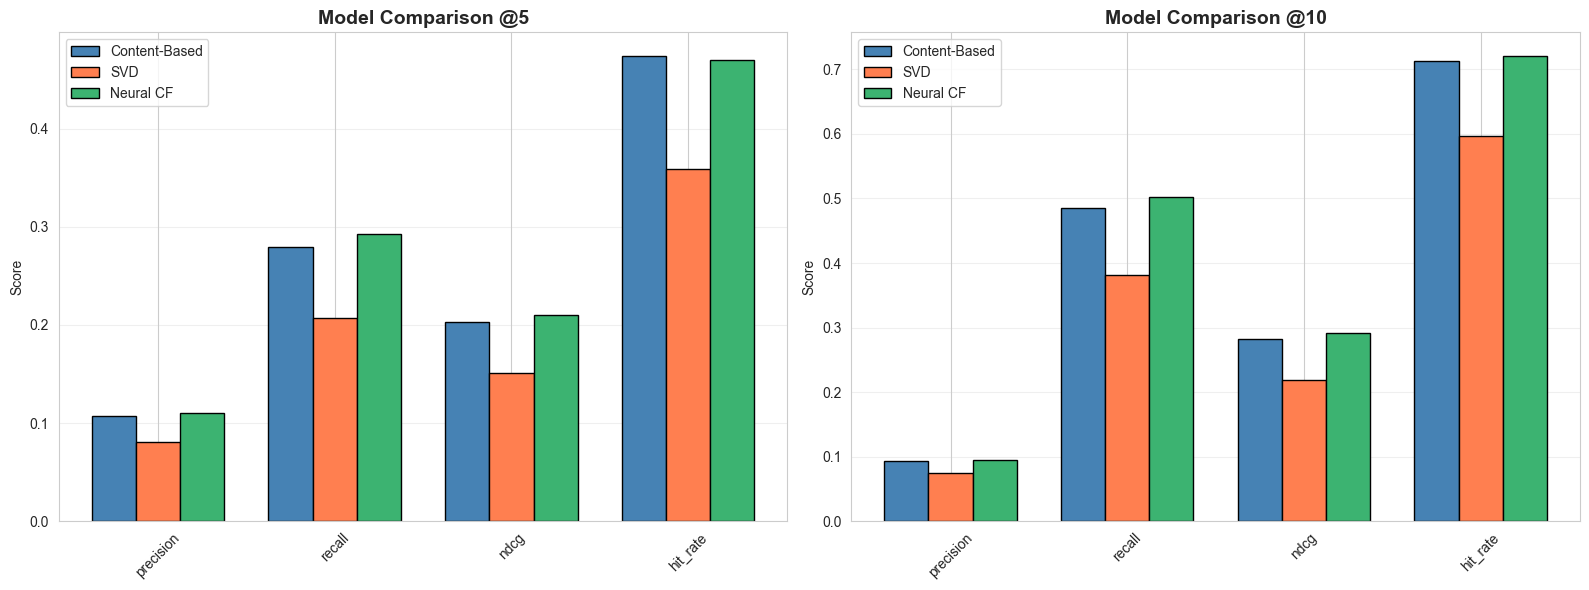

Comparison chart saved!


In [13]:
# Visualization: side-by-side comparison
metrics_5 = ['precision@5', 'recall@5', 'ndcg@5', 'hit_rate@5']
metrics_10 = ['precision@10', 'recall@10', 'ndcg@10', 'hit_rate@10']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(metrics_5))
width = 0.25

for ax, metrics, title in [(axes[0], metrics_5, '@5'), (axes[1], metrics_10, '@10')]:
    cb_vals = [cb[m] for m in metrics]
    cf_vals = [cf[m] for m in metrics]
    ncf_vals = [ncf[m] for m in metrics]
    
    ax.bar(x - width, cb_vals, width, label='Content-Based', color='steelblue', edgecolor='black')
    ax.bar(x, cf_vals, width, label='SVD', color='coral', edgecolor='black')
    ax.bar(x + width, ncf_vals, width, label='Neural CF', color='mediumseagreen', edgecolor='black')
    
    ax.set_xticks(x)
    ax.set_xticklabels([m.split('@')[0] for m in metrics], rotation=45)
    ax.set_title(f'Model Comparison {title}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/11_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('Comparison chart saved!')

## 6. Summary

### Neural Collaborative Filtering
**Architecture:** GMF (element-wise product) + MLP (deep layers) merged for prediction.

**Strengths:**
- Can model non-linear user-exercise relationships
- Combines benefits of matrix factorization + deep learning
- Flexible — easy to add side features (user age, exercise difficulty, etc.)

**Weaknesses:**
- Needs more data to shine (our 51-exercise dataset is small)
- Longer training time
- Harder to interpret
- Risk of overfitting on small datasets

### Key Takeaways Across All Models
- Content-based has a natural advantage here because our synthetic data was generated using content rules
- With real user data, collaborative and neural approaches would likely improve significantly
- The comparison demonstrates understanding of trade-offs — this is what matters for your application